## Anime Classification & Recommendation Engine

#### Data: 14,578 anime titles scrapped from Anime Planet
#### Aims: To identify features that can classify an anime based on demographic, and develop a recommendation engine
#### Part 1: Prepare and clean data

In [1]:
# Import libraries

import re
import math
import imblearn
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from sklearn import ensemble

from sklearn.preprocessing import label_binarize

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from itertools import cycle


%matplotlib inline

In [2]:
# Load and read data

anime = pd.read_csv('anime.csv', na_values = '[]', keep_default_na=True)
anime.head()

,title,mediaType,eps,duration,ongoing,startYr,finishYr,sznOfRelease,description,studios,tags,contentWarn,watched,watching,wantWatch,dropped,rating,votes
0,Fullmetal Alchemist: Brotherhood,TV,64.0,NaN,False,2009.0,2010.0,Spring,The foundation of alchemy is based on the law ...,['Bones'],"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,NaN,Mitsuha and Taki are two total strangers livin...,['CoMix Wave Films'],"['Drama', 'Romance', 'Body Swapping', 'Gender ...",NaN,58831.0,1453,21733,124,4.663,43960.0
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,NaN,"After transferring into a new school, a deaf g...",['Kyoto Animation'],"['Drama', 'Shounen', 'Disability', 'Melancholy...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,NaN,False,2016.0,2016.0,Fall,"Picking up where the second season ended, the ...",['Production I.G'],"['Shounen', 'Sports', 'Animeism', 'School Club...",NaN,25134.0,2183,8082,167,4.660,17422.0
4,Attack on Titan 3rd Season: Part II,TV,10.0,NaN,False,2019.0,2019.0,Spring,The battle to retake Wall Maria begins now! Wi...,['Wit Studio'],"['Action', 'Fantasy', 'Horror', 'Shounen', 'Da...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0


In [3]:
# Check datatypes

anime.dtypes

title            object
mediaType        object
eps             float64
duration        float64
ongoing            bool
startYr         float64
finishYr        float64
sznOfRelease     object
description      object
studios          object
tags             object
contentWarn      object
watched         float64
watching          int64
wantWatch         int64
dropped           int64
rating          float64
votes           float64
dtype: object

In [4]:
# Overview of dataset

print('Number of rows:', anime.shape[0])
print('Number of columns:', anime.shape[1])
print('Overview:', anime.info())

Number of rows: 14578
Number of columns: 18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14578 entries, 0 to 14577
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         14578 non-null  object 
 1   mediaType     14510 non-null  object 
 2   eps           14219 non-null  float64
 3   duration      9137 non-null   float64
 4   ongoing       14578 non-null  bool   
 5   startYr       14356 non-null  float64
 6   finishYr      14134 non-null  float64
 7   sznOfRelease  3767 non-null   object 
 8   description   8173 non-null   object 
 9   studios       9770 non-null   object 
 10  tags          14193 non-null  object 
 11  contentWarn   1429 non-null   object 
 12  watched       14356 non-null  float64
 13  watching      14578 non-null  int64  
 14  wantWatch     14578 non-null  int64  
 15  dropped       14578 non-null  int64  
 16  rating        12107 non-null  float64
 17  votes         12119 non-n

In [5]:
# Summary of NA values

total = anime.isnull().sum().sort_values(ascending=False)
percent = (total/anime.isnull().count()).sort_values(ascending=False)*100
dtype = anime.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table

,Total,%,Dtype
contentWarn,13149,90.197558,object
sznOfRelease,10811,74.159693,object
description,6405,43.936068,object
duration,5441,37.323364,float64
studios,4808,32.981205,object
rating,2471,16.950199,float64
votes,2459,16.867883,float64
finishYr,444,3.045685,float64
tags,385,2.640966,object
eps,359,2.462615,float64


In [6]:
# Remove titles that are not released yet
# Remove columns not suitable for ML
# Rename columns
# Remove titles that are still ongoing

anime = anime.loc[anime['startYr'] <= 2020]
anime = anime.drop(['sznOfRelease','description'], axis = 1)
anime.rename(columns={"finishYr": "finish_year", "startYr": "start_year", "mediaType": "media_type", "wantWatch": "watch_list", "contentWarn": "content_warning", "duration": "ep_duration"}, inplace = True)
anime = anime[anime.ongoing != True]
anime.head()

,title,media_type,eps,ep_duration,ongoing,start_year,finish_year,studios,tags,content_warning,watched,watching,watch_list,dropped,rating,votes
0,Fullmetal Alchemist: Brotherhood,TV,64.0,NaN,False,2009.0,2010.0,['Bones'],"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,['CoMix Wave Films'],"['Drama', 'Romance', 'Body Swapping', 'Gender ...",NaN,58831.0,1453,21733,124,4.663,43960.0
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,['Kyoto Animation'],"['Drama', 'Shounen', 'Disability', 'Melancholy...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,NaN,False,2016.0,2016.0,['Production I.G'],"['Shounen', 'Sports', 'Animeism', 'School Club...",NaN,25134.0,2183,8082,167,4.660,17422.0
4,Attack on Titan 3rd Season: Part II,TV,10.0,NaN,False,2019.0,2019.0,['Wit Studio'],"['Action', 'Fantasy', 'Horror', 'Shounen', 'Da...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0


In [7]:
# Clean data & drop/replace null values
# Duration, Rating, Votes, Watched: Replace NA values with median 
# Start Year, End Year, Episodes: Replace NA values with mean
# Set studios, tags and content_warning as strings

anime[['ep_duration', 'rating', 'votes', 'watched']] = anime[['ep_duration', 'rating', 'votes', 'watched']].fillna(anime[['ep_duration', 'rating', 'votes', 'watched']].median())
anime[['start_year', 'finish_year']] =  anime[['start_year', 'finish_year']].fillna(anime[['start_year', 'finish_year']].median())
anime['eps'] = anime['eps'].fillna(anime['eps'].mean())

anime['studios'] = anime[['studios']].fillna('__Unknown__')
anime['studios'] = anime['studios'].apply(lambda x: str(x)[2:-2])

anime['tags'] = anime['tags'].apply(lambda x: str(x)[1:-1])
anime.head()

,title,media_type,eps,ep_duration,ongoing,start_year,finish_year,studios,tags,content_warning,watched,watching,watch_list,dropped,rating,votes
0,Fullmetal Alchemist: Brotherhood,TV,64.0,8.0,False,2009.0,2010.0,Bones,"'Action', 'Adventure', 'Drama', 'Fantasy', 'My...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,CoMix Wave Films,"'Drama', 'Romance', 'Body Swapping', 'Gender B...",NaN,58831.0,1453,21733,124,4.663,43960.0
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,Kyoto Animation,"'Drama', 'Shounen', 'Disability', 'Melancholy'...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,8.0,False,2016.0,2016.0,Production I.G,"'Shounen', 'Sports', 'Animeism', 'School Club'...",NaN,25134.0,2183,8082,167,4.660,17422.0
4,Attack on Titan 3rd Season: Part II,TV,10.0,8.0,False,2019.0,2019.0,Wit Studio,"'Action', 'Fantasy', 'Horror', 'Shounen', 'Dar...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0


In [8]:
# Function for converting NaN values

def isNaN(num):
    return num != num

In [9]:
# Convert content_warning from strings to numerical values
# Compute warning counts
# Compute total score

anime['warnings_count'] = anime.content_warning.apply(lambda x: len(x.split(',')) if not isNaN(x) else 0)
anime['total_score'] = anime['rating'] * anime['votes']
anime.head()

,title,media_type,eps,ep_duration,ongoing,start_year,finish_year,studios,tags,content_warning,watched,watching,watch_list,dropped,rating,votes,warnings_count,total_score
0,Fullmetal Alchemist: Brotherhood,TV,64.0,8.0,False,2009.0,2010.0,Bones,"'Action', 'Adventure', 'Drama', 'Fantasy', 'My...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0,4,406943.994
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,CoMix Wave Films,"'Drama', 'Romance', 'Body Swapping', 'Gender B...",NaN,58831.0,1453,21733,124,4.663,43960.0,0,204985.480
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,Kyoto Animation,"'Drama', 'Shounen', 'Disability', 'Melancholy'...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0,3,157318.072
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,8.0,False,2016.0,2016.0,Production I.G,"'Shounen', 'Sports', 'Animeism', 'School Club'...",NaN,25134.0,2183,8082,167,4.660,17422.0,0,81186.520
4,Attack on Titan 3rd Season: Part II,TV,10.0,8.0,False,2019.0,2019.0,Wit Studio,"'Action', 'Fantasy', 'Horror', 'Shounen', 'Dar...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0,2,73418.850


In [10]:
# Drop NA values for media_type
# Summary of NA values

anime = anime.dropna(subset = ['media_type'])
total = anime.isnull().sum().sort_values(ascending=False)
percent = (total/anime.isnull().count()).sort_values(ascending=False)*100
dtype = anime.dtypes
na_table = pd.concat([total,percent,dtype], axis=1, keys=['Total', '%', 'Dtype'])
na_table

,Total,%,Dtype
content_warning,12620,89.962931,object
media_type,0,0.000000,object
warnings_count,0,0.000000,int64
votes,0,0.000000,float64
rating,0,0.000000,float64
dropped,0,0.000000,int64
watch_list,0,0.000000,int64
watching,0,0.000000,int64
watched,0,0.000000,float64
title,0,0.000000,object


In [11]:
anime['media_type'].value_counts()

TV             4316
Movie          2460
OVA            2069
Music Video    1593
Web            1435
DVD Special     843
Other           707
TV Special      605
Name: media_type, dtype: int64

In [12]:
# Remove rows for Music Video + DVD special

values = ['Music Video', 'DVD Special', 'TV Special']
anime = anime[anime.media_type.isin(values) == False]
anime.head()

,title,media_type,eps,ep_duration,ongoing,start_year,finish_year,studios,tags,content_warning,watched,watching,watch_list,dropped,rating,votes,warnings_count,total_score
0,Fullmetal Alchemist: Brotherhood,TV,64.0,8.0,False,2009.0,2010.0,Bones,"'Action', 'Adventure', 'Drama', 'Fantasy', 'My...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0,4,406943.994
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,CoMix Wave Films,"'Drama', 'Romance', 'Body Swapping', 'Gender B...",NaN,58831.0,1453,21733,124,4.663,43960.0,0,204985.480
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,Kyoto Animation,"'Drama', 'Shounen', 'Disability', 'Melancholy'...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0,3,157318.072
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,8.0,False,2016.0,2016.0,Production I.G,"'Shounen', 'Sports', 'Animeism', 'School Club'...",NaN,25134.0,2183,8082,167,4.660,17422.0,0,81186.520
4,Attack on Titan 3rd Season: Part II,TV,10.0,8.0,False,2019.0,2019.0,Wit Studio,"'Action', 'Fantasy', 'Horror', 'Shounen', 'Dar...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0,2,73418.850


In [13]:
anime['media_type'].value_counts()

TV       4316
Movie    2460
OVA      2069
Web      1435
Other     707
Name: media_type, dtype: int64

In [14]:
# Overview of revised dataset

print('Number of rows:', anime.shape[0])
print('Number of columns:', anime.shape[1])
print('Overview:', anime.info())

Number of rows: 10987
Number of columns: 18
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10987 entries, 0 to 14575
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            10987 non-null  object 
 1   media_type       10987 non-null  object 
 2   eps              10987 non-null  float64
 3   ep_duration      10987 non-null  float64
 4   ongoing          10987 non-null  bool   
 5   start_year       10987 non-null  float64
 6   finish_year      10987 non-null  float64
 7   studios          10987 non-null  object 
 8   tags             10987 non-null  object 
 9   content_warning  1268 non-null   object 
 10  watched          10987 non-null  float64
 11  watching         10987 non-null  int64  
 12  watch_list       10987 non-null  int64  
 13  dropped          10987 non-null  int64  
 14  rating           10987 non-null  float64
 15  votes            10987 non-null  float64
 16  warnings_count

In [15]:
# Create function to extract keywords for demographic category

def get_category(text):
    categories = 'Shounen|Seinen|Shoujo|Josei'
    cat_list = [str(s) for s in re.findall(categories, text, flags=re.IGNORECASE)]
    return cat_list

anime['demographic'] = anime['tags'].apply(get_category)
anime['demographic'] = anime['demographic'].apply(lambda x: str(x)[2:-2])
anime['demographic'] = anime['demographic'].replace(r'^\s*$', 'All', regex=True)
anime['demographic'].value_counts()

All                  8099
Shounen              1621
Seinen                800
Shoujo                367
Josei                  72
Shoujo', 'Shounen      17
Seinen', 'Shoujo       10
Seinen', 'Shounen       1
Name: demographic, dtype: int64

In [16]:
# Adjust entries with two demographic keywords - use less prominent category

anime['demographic'] = anime['demographic'].replace(['Shoujo\', \'Shounen','Seinen\', \'Shoujo', 'Seinen\', \'Shounen'], ['Shoujo', 'Shoujo', 'Seinen'])
anime['demographic'].value_counts()

All        8099
Shounen    1621
Seinen      801
Shoujo      394
Josei        72
Name: demographic, dtype: int64

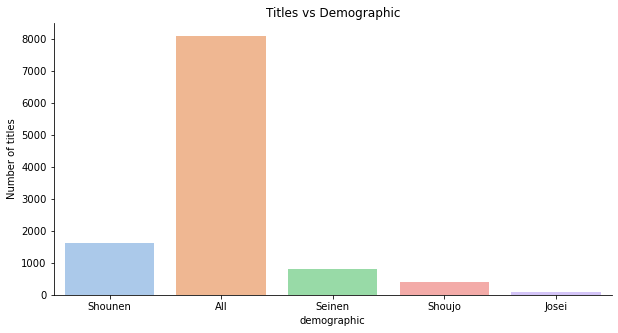

In [17]:
# Visualisation

plt.figure(figsize=(10, 5))
sns.countplot(x="demographic", data=anime, palette ='pastel')
plt.title('Titles vs Demographic')
plt.ylabel('Number of titles')
sns.despine()
plt.show()

In [18]:
# Convert tags to tag_counts

anime['tag_counts'] = anime.tags.apply(lambda x: len(x.split(',')) if not isNaN(x) else 0)
anime.head()

,title,media_type,eps,ep_duration,ongoing,start_year,finish_year,studios,tags,content_warning,watched,watching,watch_list,dropped,rating,votes,warnings_count,total_score,demographic,tag_counts
0,Fullmetal Alchemist: Brotherhood,TV,64.0,8.0,False,2009.0,2010.0,Bones,"'Action', 'Adventure', 'Drama', 'Fantasy', 'My...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0,4,406943.994,Shounen,10
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,CoMix Wave Films,"'Drama', 'Romance', 'Body Swapping', 'Gender B...",NaN,58831.0,1453,21733,124,4.663,43960.0,0,204985.480,All,8
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,Kyoto Animation,"'Drama', 'Shounen', 'Disability', 'Melancholy'...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0,3,157318.072,Shounen,7
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,8.0,False,2016.0,2016.0,Production I.G,"'Shounen', 'Sports', 'Animeism', 'School Club'...",NaN,25134.0,2183,8082,167,4.660,17422.0,0,81186.520,Shounen,8
4,Attack on Titan 3rd Season: Part II,TV,10.0,8.0,False,2019.0,2019.0,Wit Studio,"'Action', 'Fantasy', 'Horror', 'Shounen', 'Dar...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0,2,73418.850,Shounen,10


In [19]:
# Final dataset with target and features for EDA + ML

anime_categories = anime[['title','studios','media_type', 'eps', 'ep_duration','votes','total_score','tag_counts', 'warnings_count', 'demographic', 'watched', 'dropped']]
anime_categories.head()

,title,studios,media_type,eps,ep_duration,votes,total_score,tag_counts,warnings_count,demographic,watched,dropped
0,Fullmetal Alchemist: Brotherhood,Bones,TV,64.0,8.0,86547.0,406943.994,10,4,Shounen,103707.0,2656
1,your name.,CoMix Wave Films,Movie,1.0,107.0,43960.0,204985.480,8,0,All,58831.0,124
2,A Silent Voice,Kyoto Animation,Movie,1.0,130.0,33752.0,157318.072,7,3,Shounen,45892.0,132
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,Production I.G,TV,10.0,8.0,17422.0,81186.520,8,0,Shounen,25134.0,167
4,Attack on Titan 3rd Season: Part II,Wit Studio,TV,10.0,8.0,15789.0,73418.850,10,2,Shounen,21308.0,174


#### Part 2: Exploratory Data Analysis

In [20]:
# Earliest and latest release date

print(anime['start_year'].min())
print(anime['start_year'].max())

1907.0
2020.0


In [21]:
# Create bins and labels for titles sorted by decade

bins = [i for i in range(1910,2021,10)]
labels = [str(i)+str("-")+str(i+10) for i in range(1910,2020,10)]

anime['decade'] = pd.cut(anime['start_year'], bins=bins, labels=labels)

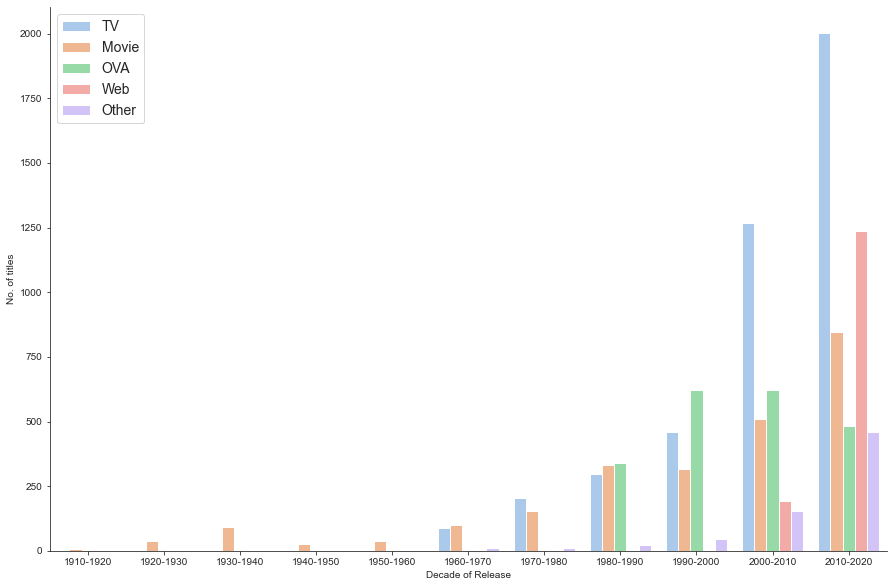

In [22]:
# Plot growth in number of titles across decades

plt.figure(figsize=(15, 10))
sns.set_style("ticks")

splot = sns.countplot(x='decade', hue='media_type', data=anime, palette ='pastel')

plt.ylabel("No. of titles")
plt.xlabel("Decade of Release")
plt.legend(loc='upper left', fontsize =14)
sns.despine()
plt.show() 

In [23]:
# Overview of numerical variables
anime_categories.describe()

,eps,ep_duration,votes,total_score,tag_counts,warnings_count,watched,dropped
count,10987.000000,10987.000000,10987.000000,10987.000000,10987.000000,10987.000000,10987.000000,10987.000000
mean,15.119053,19.844271,2176.558478,8469.416114,5.497406,0.210886,2910.866023,161.316010
std,50.506997,27.233632,6163.207671,26148.616375,2.725514,0.731989,8028.478801,498.480712
min,1.000000,1.000000,10.000000,10.080000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,8.000000,66.000000,160.844500,4.000000,0.000000,29.000000,2.000000
50%,3.000000,8.000000,221.000000,654.160000,5.000000,0.000000,247.000000,11.000000
75%,13.000000,19.000000,1397.500000,4679.796000,7.000000,0.000000,1963.000000,77.000000
max,1818.000000,235.000000,131067.000000,589932.567000,20.000000,9.000000,161567.000000,19481.000000


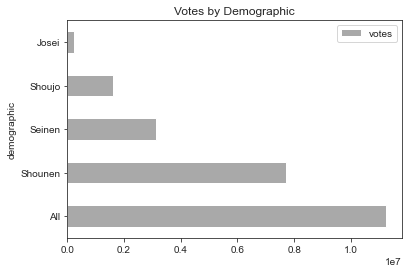

In [24]:
# Comparison of votes and demographic

anime_dem_votes = pd.pivot_table(anime_categories, index = 'demographic', values = ['votes'], aggfunc = np.sum).sort_values(by=['votes'], ascending=False)
anime_dem_votes.plot(y = 'votes', kind ='barh', color ='darkgray')
plt.title('Votes by Demographic')
plt.show()

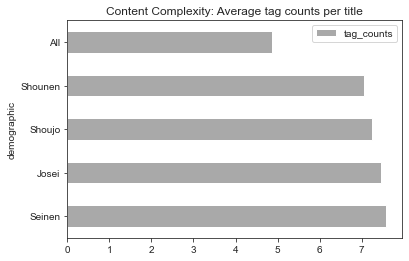

In [25]:
# Comparison of tag counts and demographic

anime_dem_tags = pd.pivot_table(anime_categories, index = 'demographic', values = ['tag_counts'], aggfunc = np.mean).sort_values(by=['tag_counts'], ascending=False)
anime_dem_tags.plot(y = 'tag_counts', kind ='barh', color ='darkgray')
plt.title('Content Complexity: Average tag counts per title')
plt.show()

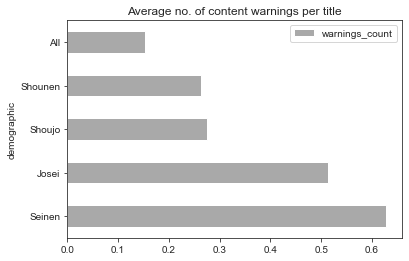

In [26]:
# Comparison of warning counts and demographic

anime_dem_tags = pd.pivot_table(anime_categories, index = 'demographic', values = ['warnings_count'], aggfunc = np.mean).sort_values(by=['warnings_count'], ascending=False)
anime_dem_tags.plot(y = 'warnings_count', kind ='barh', color ='darkgray')
plt.title('Average no. of content warnings per title')
plt.show()

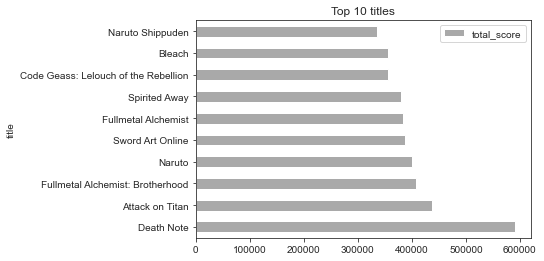

In [27]:
# Top titles

anime_titles = pd.pivot_table(anime_categories, index = 'title', values = ['total_score'], aggfunc = np.sum).sort_values(by=['total_score'], ascending = False)
anime_titles_top = anime_titles.head(10)

anime_titles_top.plot(y = 'total_score', kind ='barh', color ='darkgray')
plt.title('Top 10 titles')
plt.show()

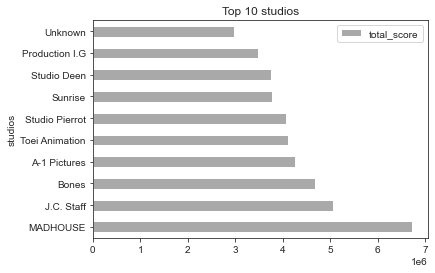

In [28]:
# Top Studios based on score

anime_studios = pd.pivot_table(anime_categories, index = 'studios', values = ['total_score'], aggfunc = np.sum).sort_values(by=['total_score'], ascending = False)
anime_studios_top = anime_studios.head(10)

anime_studios_top.plot(y = 'total_score', kind ='barh', color ='darkgray')
plt.title('Top 10 studios')
plt.show()

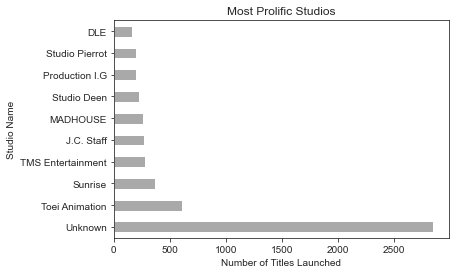

In [29]:
# Top Studios based on number of titles

anime.studios.value_counts().head(10).plot(kind = 'barh', color = 'darkgray')
plt.title('Most Prolific Studios')
plt.xlabel('Number of Titles Launched')
plt.ylabel('Studio Name')
plt.show()

In [30]:
# Explore correlations

anime_categories.corr()

,eps,ep_duration,votes,total_score,tag_counts,warnings_count,watched,dropped
eps,1.000000,-0.123331,0.059086,0.057987,0.032291,-0.025019,0.038145,0.147304
ep_duration,-0.123331,1.000000,0.019243,0.022868,0.006673,0.059122,0.044714,-0.117500
votes,0.059086,0.019243,1.000000,0.996131,0.346225,0.233510,0.987762,0.754465
total_score,0.057987,0.022868,0.996131,1.000000,0.336439,0.225094,0.981078,0.727848
tag_counts,0.032291,0.006673,0.346225,0.336439,1.000000,0.201369,0.349460,0.304159
warnings_count,-0.025019,0.059122,0.233510,0.225094,0.201369,1.000000,0.226265,0.194158
watched,0.038145,0.044714,0.987762,0.981078,0.349460,0.226265,1.000000,0.679068
dropped,0.147304,-0.117500,0.754465,0.727848,0.304159,0.194158,0.679068,1.000000


In [31]:
# Filter array

mask = np.zeros_like(anime_categories.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

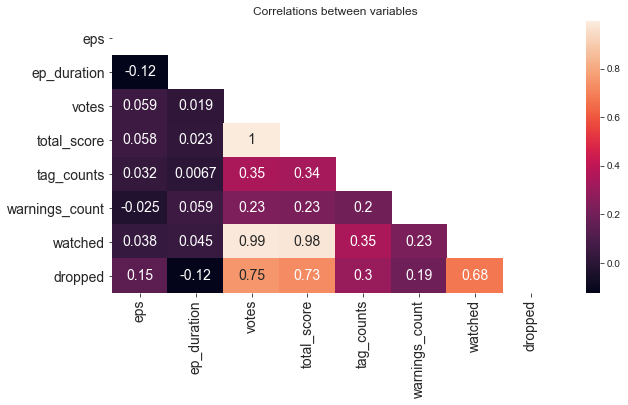

In [32]:
# Plot heatmap for visualisation

plt.figure(figsize = (10,5))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
sns.heatmap(anime_categories.corr(), mask = mask, annot = True, annot_kws = {'size': 14}) 
plt.title('Correlations between variables')
plt.show()

#### Part 3: Model Preparation

In [33]:
# Feature Encoding

label_encoded =anime_categories[['studios','eps', 'ep_duration', 'votes', 'total_score', 'tag_counts', 'warnings_count', 'watched', 'dropped']]
anime_le = label_encoded.apply(LabelEncoder().fit_transform)
anime_le.head()

,studios,eps,ep_duration,votes,total_score,tag_counts,warnings_count,watched,dropped
0,103,63,7,3512,9234,9,4,3973,1156
1,131,0,106,3472,9201,7,0,3941,124
2,311,0,128,3430,9169,6,3,3899,132
3,474,9,7,3250,9007,7,0,3729,167
4,772,9,7,3199,8973,9,2,3648,174


In [34]:
# Create and fit model

X = anime_le
Y = anime_categories['demographic'].apply(lambda x: 1 if x =='Shounen' else(2 if x == 'Seinen' else(3 if x =='Shoujo' else(4 if x == 'Josei' else 0))))

# Scale Data
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

Y.value_counts(normalize = True)

0    0.737144
1    0.147538
2    0.072904
3    0.035861
4    0.006553
Name: demographic, dtype: float64

In [35]:
# Calculate base accuracy

lst = Y.value_counts(normalize = True).tolist()
base_accuracy = sum(i*i for i in lst)
round(base_accuracy, 3)

0.572

In [36]:
# import library

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable

X_ros, y_ros = ros.fit_resample(Xs, Y)

print('Original dataset shape', Counter(Y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 8099, 1: 1621, 2: 801, 3: 394, 4: 72})
Resample dataset shape Counter({1: 8099, 0: 8099, 2: 8099, 3: 8099, 4: 8099})


In [37]:
# Binarise output

Y_ros = label_binarize(y_ros, classes=[0, 1, 2, 3, 4])
n_classes = Y_ros.shape[1]

In [38]:
# Train, test, split

X_train, X_test, Y_train, Y_test = train_test_split(X_ros, Y_ros, test_size=0.2, random_state= 42)

#### Part 3: Decision Trees

In [39]:
# Decision Trees: Training Data
# Balance weight for classes in an imbalanced data set

from sklearn import tree

dtmodel = tree.DecisionTreeClassifier()
dtmodel.fit(X_train, Y_train)
results = cross_val_score(dtmodel, X_train, Y_train, cv = 5)
print('Decision Tree, CV Mean: %.4f' % results.mean())

Decision Tree, CV Mean: 0.9475


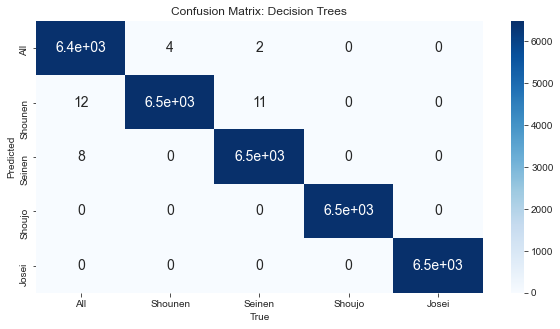

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6456
           1       1.00      1.00      1.00      6507
           2       1.00      1.00      1.00      6497
           3       1.00      1.00      1.00      6461
           4       1.00      1.00      1.00      6475

   micro avg       1.00      1.00      1.00     32396
   macro avg       1.00      1.00      1.00     32396
weighted avg       1.00      1.00      1.00     32396
 samples avg       1.00      1.00      1.00     32396



In [40]:
# DT Training Data: Confusion Matrix & Classification Report

y_pred = dtmodel.predict(X_train)

cm = metrics.confusion_matrix(np.asarray(Y_train).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

plt.figure(figsize = (10, 5))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Confusion Matrix: Decision Trees')
sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'size': 14}, xticklabels =['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'], yticklabels = ['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

print(metrics.classification_report(Y_train, y_pred, zero_division = 1))


In [41]:
# Decision Trees: Test Data

dtmodel.fit(X_test, Y_test)
results = cross_val_score(dtmodel, X_test, Y_test, cv = 5)
print('Decision Tree, CV Mean: %.4f' % results.mean())

Decision Tree, CV Mean: 0.8354


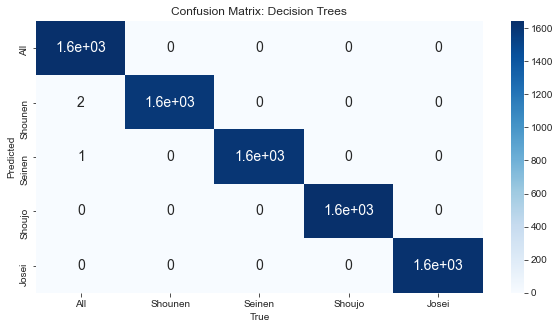

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1643
           1       1.00      1.00      1.00      1592
           2       1.00      1.00      1.00      1602
           3       1.00      1.00      1.00      1638
           4       1.00      1.00      1.00      1624

   micro avg       1.00      1.00      1.00      8099
   macro avg       1.00      1.00      1.00      8099
weighted avg       1.00      1.00      1.00      8099
 samples avg       1.00      1.00      1.00      8099



In [42]:
# DT Test Data: Confusion Matrix & Classification Report

y_pred_test = dtmodel.predict(X_test)

cm = metrics.confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_test).argmax(axis=1))

plt.figure(figsize = (10, 5))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Confusion Matrix: Decision Trees')
sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'size': 14}, xticklabels =['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'], yticklabels = ['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

print(metrics.classification_report(Y_test, y_pred_test, zero_division = 1))


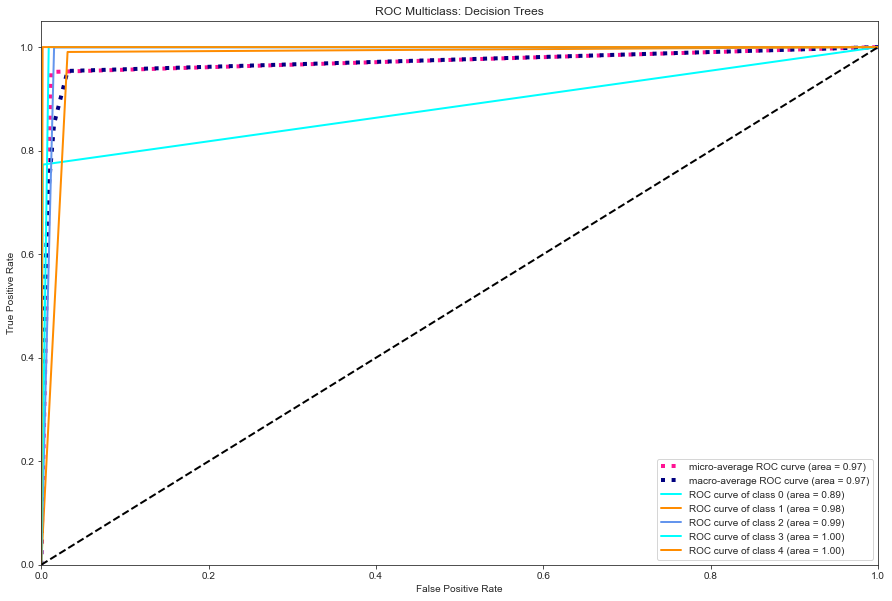

In [43]:
y_score = dtmodel.fit(X_train, Y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw =2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Multiclass: Decision Trees")
plt.legend(loc="lower right")
plt.show()

#### Part 4: Random Forests

In [44]:
# RF: Training Data

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, random_state=42)
rf.fit(X_train, Y_train)
results = cross_val_score(rf, X_train, Y_train, cv = 5)
print('Random Forest, CV Mean: %.4f' % results.mean())

Random Forest, CV Mean: 0.9364


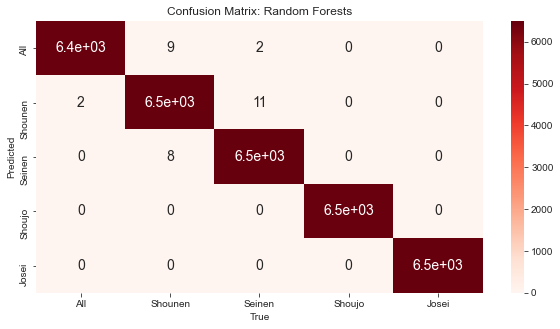

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6456
           1       1.00      1.00      1.00      6507
           2       1.00      1.00      1.00      6497
           3       1.00      1.00      1.00      6461
           4       1.00      1.00      1.00      6475

   micro avg       1.00      1.00      1.00     32396
   macro avg       1.00      1.00      1.00     32396
weighted avg       1.00      1.00      1.00     32396
 samples avg       1.00      1.00      1.00     32396



In [45]:
# RF Training Data: Confusion Matrix & Classification Report

y_pred_rf = rf.predict(X_train)

cm = metrics.confusion_matrix(np.asarray(Y_train).argmax(axis=1), np.asarray(y_pred_rf).argmax(axis=1))

plt.figure(figsize = (10, 5))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Confusion Matrix: Random Forests')
sns.heatmap(cm, annot = True, cmap = 'Reds', annot_kws = {'size': 14}, xticklabels =['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'], yticklabels = ['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'])
plt.xlabel('True')
plt.ylabel('Predicted') 
plt.show()

print(metrics.classification_report(Y_train, y_pred_rf, zero_division =1))

In [46]:
# RF: Test Data

rf.fit(X_test, Y_test)
results = cross_val_score(rf, X_test, Y_test, cv = 5)
print('Random Forest, CV Mean: %.4f' % results.mean())

Random Forest, CV Mean: 0.7955


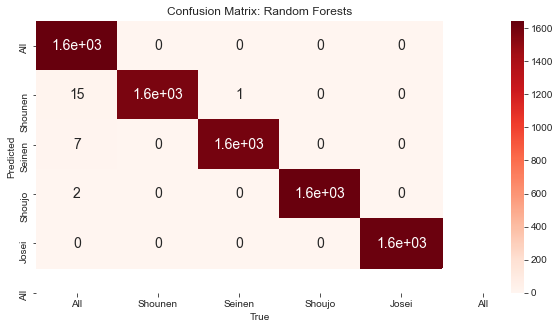

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1643
           1       1.00      0.99      0.99      1592
           2       1.00      1.00      1.00      1602
           3       1.00      1.00      1.00      1638
           4       1.00      1.00      1.00      1624

   micro avg       1.00      1.00      1.00      8099
   macro avg       1.00      1.00      1.00      8099
weighted avg       1.00      1.00      1.00      8099
 samples avg       1.00      1.00      1.00      8099



In [47]:
# RF Test Data: Confusion Matrix & Classification Report

y_pred_rf_test = rf.predict(X_test)

cm = metrics.confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_rf_test).argmax(axis=1))

plt.figure(figsize = (10, 5))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Confusion Matrix: Random Forests')
sns.heatmap(cm, annot = True, cmap = 'Reds', annot_kws = {'size': 14}, xticklabels =['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei', 'All'], yticklabels = ['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei', 'All'])
plt.xlabel('True')
plt.ylabel('Predicted') 
plt.show()

print(metrics.classification_report(Y_test, y_pred_rf_test, zero_division =1))

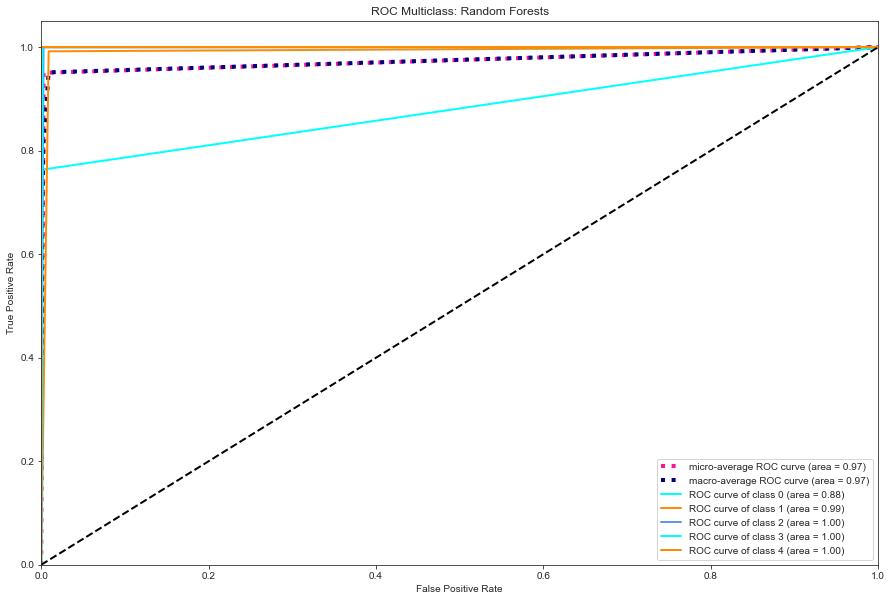

In [48]:
y_score = rf.fit(X_train, Y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw =2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Multiclass: Random Forests")
plt.legend(loc="lower right")
plt.show()

#### Part 5: OvR(LinearSVC)

In [49]:
# Import libraries

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from itertools import cycle

X = anime_le
y = anime_categories['demographic'].apply(lambda x: 1 if x =='Seinen' else(2 if x == 'Shoujo' else(3 if x =='Josei' else 0)))


# Scale Data
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Binarise output
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LinearSVC(max_iter = 1000, dual=False))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [50]:
classifier.fit(X_train, y_train)
results = cross_val_score(classifier, X_train, y_train, cv = 5)
print('OvR-SVC, CV Mean: %.4f' % results.mean())

OvR-SVC, CV Mean: 0.8844


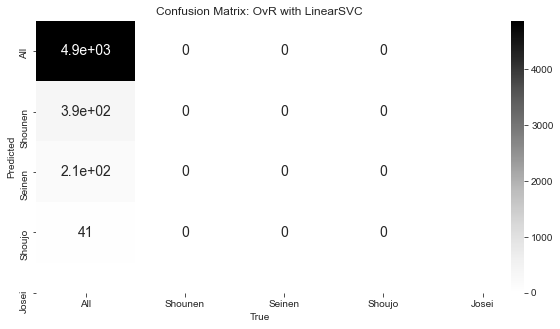

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4859
           1       1.00      0.00      0.00       386
           2       1.00      0.00      0.00       207
           3       1.00      0.00      0.00        41

   micro avg       0.89      0.88      0.88      5493
   macro avg       0.97      0.25      0.23      5493
weighted avg       0.90      0.88      0.83      5493
 samples avg       0.89      0.88      0.88      5493



In [51]:
y_pred= classifier.predict(X_train)

cm = metrics.confusion_matrix(np.asarray(y_train).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

plt.figure(figsize = (10, 5))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Confusion Matrix: OvR with LinearSVC')
sns.heatmap(cm, annot = True, cmap = 'Greys', annot_kws = {'size': 14}, xticklabels =['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'], yticklabels = ['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

print(metrics.classification_report(y_train, y_pred, zero_division = 1))


In [52]:
classifier.fit(X_test, y_test)
results = cross_val_score(classifier, X_test, y_test, cv = 5)
print('OvR-SVC, CV Mean: %.4f' % results.mean())

OvR-SVC, CV Mean: 0.8837


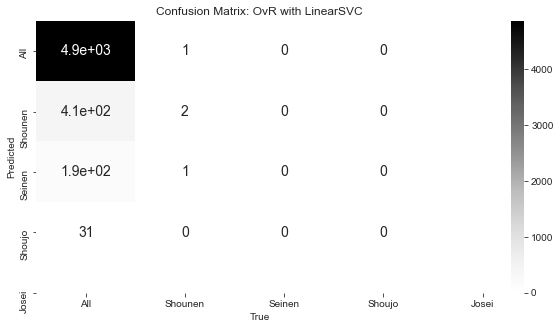

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4861
           1       0.50      0.00      0.01       415
           2       1.00      0.00      0.00       187
           3       1.00      0.00      0.00        31

   micro avg       0.89      0.88      0.88      5494
   macro avg       0.85      0.25      0.24      5494
weighted avg       0.86      0.88      0.83      5494
 samples avg       0.89      0.88      0.88      5494



In [53]:
y_pred_test = classifier.predict(X_test)

cm = metrics.confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred_test).argmax(axis=1))

plt.figure(figsize = (10, 5))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Confusion Matrix: OvR with LinearSVC')
sns.heatmap(cm, annot = True, cmap = 'Greys', annot_kws = {'size': 14}, xticklabels =['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'], yticklabels = ['All', 'Shounen', 'Seinen', 'Shoujo', 'Josei'])
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_pred_test, zero_division = 1))


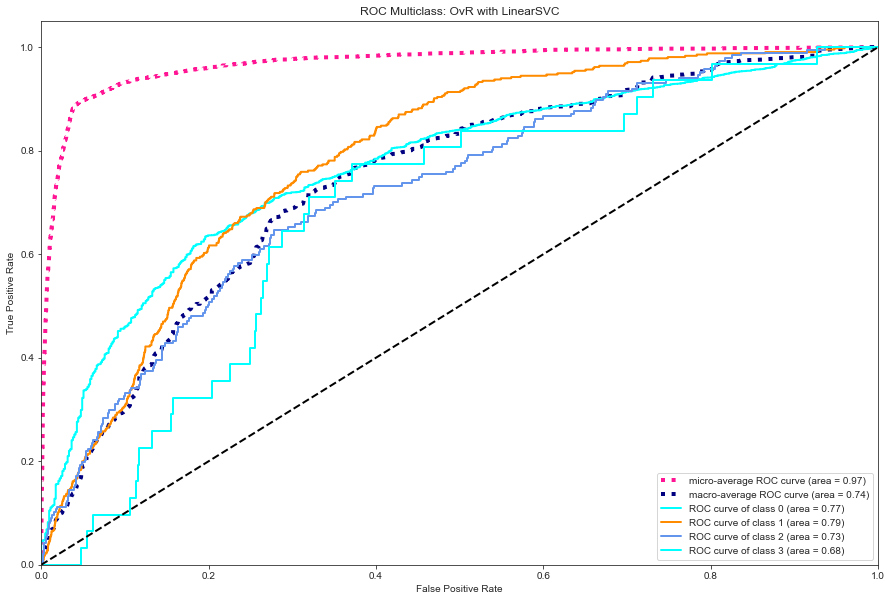

In [54]:
lw =2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Multiclass: OvR with LinearSVC")
plt.legend(loc="lower right")
plt.show()